## In this assignment, we will implement a simple rule-based POS tagger

First let's download the universal dependency treebank from the following url https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-4611

Create a folder named `data`. Copy the downloaded `ud-treebanks-v2.9.tgz` file into the current directory and untar it

let us import some libraries

In [1]:
import codecs
import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt

Now let's write some utility functions

### Utility Code

#### Code to read data from CoNLL format

In [2]:
def conllReader(filename, word_field=1, label_field=3):
    sentences = []
    sentence = []
    label_list = []
    
    with codecs.open(filename, 'r', errors='ignore', encoding='utf8') as f_in:
        for line in f_in:
            line = line.strip()
            if line:
                if line.startswith('#'):
                    continue
                word = line.split('\t')[word_field]
                label = line.split('\t')[label_field]
                tokens = [word, label]
                sentence.append( tokens )
                
                if label not in label_list:
                    label_list.append( label )
            else:
                if len(sentence) > 0:
                    sentences.append( sentence )
                sentence = []
        f_in.close()
        
    return sentences, label_list

In [3]:
train_split, label_list = conllReader('data/ud-treebanks-v2.9/UD_Hindi-HDTB/hi_hdtb-ud-train.conllu', word_field=1, label_field=3)
label_list.sort()
print('Read {0} number of train sentences'.format( len(train_split) ))
print('\nFirst sentence looks like')
print(train_split[0])

print('\n Labels used are')
print(label_list)

Read 13304 number of train sentences

First sentence looks like
[['यह', 'DET'], ['एशिया', 'PROPN'], ['की', 'ADP'], ['सबसे', 'ADV'], ['बड़ी', 'ADJ'], ['मस्जिदों', 'NOUN'], ['में', 'ADP'], ['से', 'ADP'], ['एक', 'NUM'], ['है', 'AUX'], ['।', 'PUNCT']]

 Labels used are
['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'VERB', 'X']


In [4]:
def getMax(dictionary):    
    max_key = list(dictionary.keys())[0]
    max_value = dictionary[max_key]
    for key in dictionary:
        if max_value > dictionary[key]:
            max_value = dictionary[key]
            max_key = key
            
    return key

Now we have the data loading part written, let's write a simple Most-Frequent POS tagger 

### Most Frequent POS Tagger

Let's load the train and test sets

In [5]:
train_split, label_list = conllReader('data/ud-treebanks-v2.9/UD_Hindi-HDTB/hi_hdtb-ud-train.conllu', word_field=1, label_field=3)
test_split, _ = conllReader('data/ud-treebanks-v2.9/UD_Hindi-HDTB/hi_hdtb-ud-test.conllu', word_field=1, label_field=3)

print('Read {0} number of train sentences'.format( len(train_split) ))
print('Read {0} number of test sentences'.format( len(test_split) ))

Read 13304 number of train sentences
Read 1684 number of test sentences


For every word in train split, let's get the POS statistics

In [6]:
word_pos_frequency = {}

for every_sentence in train_split:
    for every_token in every_sentence:
        word, label = every_token
        if word in word_pos_frequency:
            if label in word_pos_frequency[word]:
                word_pos_frequency[word][label] += 1
            else:
                word_pos_frequency[word][label] = 1
        else:
            word_pos_frequency[word] = {}
            word_pos_frequency[word][label] = 1
            
print('Total number of words in train split is {0}'.format( len(word_pos_frequency) ) )
first_word = next(iter(word_pos_frequency))
print( 'Word is {0}'.format(first_word) )
print( word_pos_frequency[first_word] )

Total number of words in train split is 16879
Word is यह
{'DET': 658, 'PRON': 573, 'NOUN': 1}


### Evaluate on test split

In [7]:
ground_truth = []
prediction = []

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )

        if word in word_pos_frequency:
            prediction_sentence.append( getMax( word_pos_frequency[word] ) )
        else:
            prediction_sentence.append( random.choice( label_list ) )
            
    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [8]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]
label_list.sort()
print(classification_report(flatten_gold_truth, flatten_predictions, target_names=label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.4962    0.6667    0.5690     16459
         ADP     0.8807    0.2457    0.3843     59221
         ADV     0.2227    0.3552    0.2737      2703
         AUX     0.0936    0.1350    0.1106     20821
       CCONJ     1.0000    0.2372    0.3834      5110
         DET     0.1115    0.1210    0.1161      6081
        INTJ     1.0000    1.0000    1.0000         3
        NOUN     0.6175    0.6462    0.6315     62191
         NUM     0.8006    0.3329    0.4703      5332
        PART     0.3651    0.5358    0.4343      5610
        PRON     0.5566    0.7281    0.6309     11857
       PROPN     0.3714    0.6528    0.4735     34289
       PUNCT     1.0000    1.0000    1.0000     18668
       SCONJ     1.0000    0.1202    0.2147      5389
        VERB     0.6276    0.6397    0.6336     27188
           X     0.0451    0.6444    0.0843       135

    accuracy                         0.5125    281057
   macro avg     0.5743   

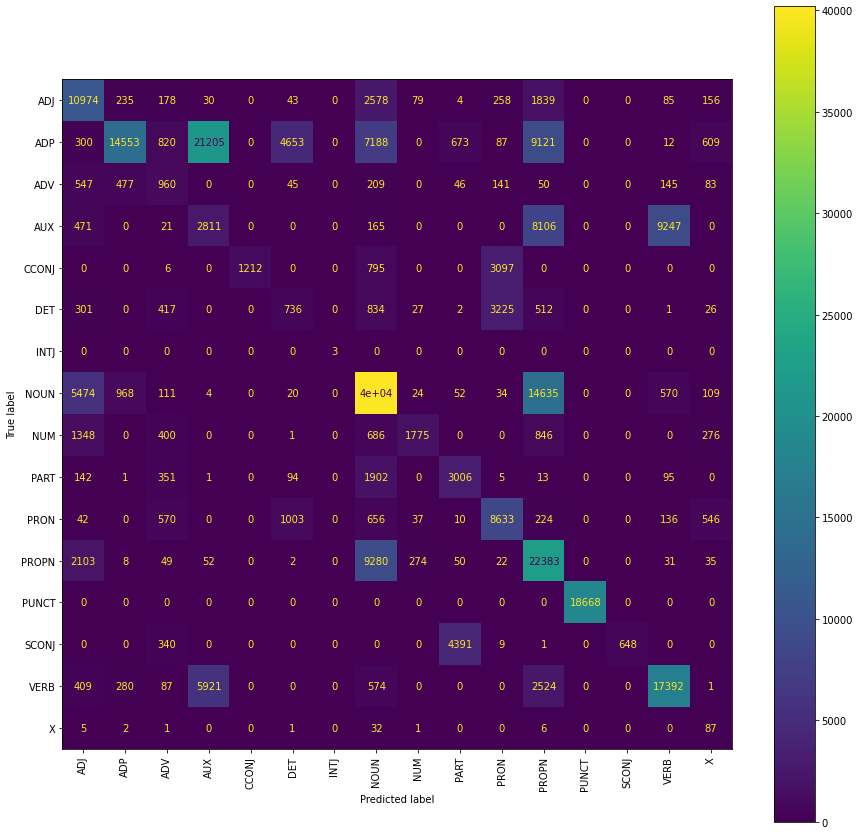

In [9]:
cm = confusion_matrix(flatten_gold_truth, flatten_predictions)

cmd = ConfusionMatrixDisplay(cm, display_labels=label_list)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

cmd.plot(xticks_rotation='vertical', ax =ax)

In [10]:
    
#For tasks requiring phrase-level annotation
# from seqeval.metrics import accuracy_score
# from seqeval.metrics import classification_report
# from seqeval.metrics import f1_score
# from seqeval.scheme import IOB1
# print('F1 Score is')
# print( f1_score(ground_truth, prediction) )

# print('Classification report')
# print( classification_report(ground_truth, prediction, scheme=IOB1) )

## Implement Rule-based System here

In [10]:
INDIC_NLP_RESOURCES=r"C:\Users\akash\IIITL_NLP_Lab\Lab01\indic_nlp_resources"

In [11]:
import sys
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)

In [12]:
from indicnlp import loader
loader.load()

In [13]:
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

factory=IndicNormalizerFactory()
normalizer=factory.get_normalizer("hi")

### Rules for Hindi language

In [25]:
hindi_num = '०१२३४५६७८९0123456789' # digits in hindi and english from 0-9
hindi_num_text = ['शून्य','एक', 'डेढ़', 'दो', 'दोनों', 'तीन', 'चार', 'चारों', 'पाँच', 'पांच', 'छह', 'सात', 'आठ', 'नौ', 'दस', 'पचास', 'सौ',
                  'हज़ार', 'लाख', 'लाखों', 'करोड़', 'अरब'] # most common hindi numbers 

def chk_num(word):
    for chr in word:
        if chr in hindi_num:
            return True
    if word in hindi_num_text:
        return True
    return False
        

def chk_det(word):
    common_det_list = ['उसका', 'उसकी', 'उसके', 'मेरा', 'मेरी', 'आपका', 'आपकी', 'यह', 'वह', 'ये', 'वो', 'वे',
               'कुछ', 'कई', 'ऐसे', 'ऐसी', 'ऐसा', 'इस', 'उस', 'इन', 'इनकी']
    if word in common_det_list:
        return True
    else:
        return False
    
    
def chk_adp(word):
    if ((word == 'का') or (word == 'के') or (word == 'को') or (word == 'से') or (word == 'में') or (word == 'पर') or (word == 'की') or 
        (word == 'लिए')):
        return True
    else:
        return False

def chk_sconj(word):
    if (word == 'तो') or (word == 'कि') or (word == 'यदि') or (word == 'क्योंकि') or (word == 'बल्कि'):
        return True
    else:
        return False
    
def chk_aux(word):
    if word == 'है' or word == 'हैं':
        return True
    else:
        return False
    
def chk_cconj(word):
    if (word == 'लेकिन') or (word == 'और') or (word == 'व') or (word == 'या'):
        return True
    else:
        return False
    
def chk_part(word):
    part_ls = ['नहीं', 'भी', 'ही', 'न', 'केवल', 'भर']
    if word in part_ls:
        return True
    else:
        return False

INTJs = ['हे', 'अरे', 'ऐ', 'ओह', 'शाबाश', 'वाह']

advs = ['अच्छा', 'कल', 'ऊपर', 'थोडा', 'ध्यानपूर्वक', 'भली', 'भाँति', 'धीरे', 'तेज', 'बाद', 'फिलहाल', 'जमकर', 'दौरान', 'अंदर', 'बाहर',
        'सबसे', 'पहले', 'जरूर' , 'अक्सर' , 'शायद' , 'इसलिए', 'कभी', 'बिल्कुल', 'तक', 'अचानक', 'प्रतिदिन', 'आज', 'जब', 'तब',
        'अभी', 'रोज ', 'आगे', 'पीछे', 'नीचे', 'दाएँ', 'बाएँ', 'उतना', 'जितना', 'अधिक', 'कम', 'खूब', 'इतना', 'शीघ्र', 'लगातार', 
       'खुलकर', 'फिर', 'जैसे', 'बेहद', 'बहुत', 'यूँ', 'काफी', 'वहीं'] 
    
# def chk_adj_with_pos(word, ps, pps):
    
#     lst_c = word[len(word)-1]
#     hcf1 = hex(ord(word[0]))
#     hcf2 = 0x20
#     hcl1 = hex(ord(lst_c))
#     hcl2 = 0x20
    
#     if len(word) > 1:
#         sec_lst_c = word[len(word)-2]
#         hcl2 = hex(ord(sec_lst_c))
#         hcf2 = hex(ord(word[1]))
#     if pps != 'ADJ':    
#         if ps == 'NOUN':
#             if ((hcf1 == '0x926' and hcf2 == '0x941') or (hcf1 == '0x92c' and hcf2 == '0x926') or 
#             (hcf1 == '0x92c' and hcf2 == '0x947')): # checking prefixes for adj
#                 return True
    
#             elif ((hcl2 == '0x93f' and hcl1 == '0x915') or (hcl2 == '0x93f' and hcl1 == '0x924') or
#             (hcl2 == '0x93f' and hcl1 == '0x92e') or (hcl2 == '0x940'  and (hcl1 != '0x915' or hcl1 != '0x930' or hcl1 != '0x939' or hcl1 != '0x92d')) or 
#             (hcl2 == '0x93f' and (hcl1 != '0x926' or hcl1 != '0x90f' or hcl1 != '0x928')) or
#                  (hcl1 == '0x940') or (hcl1 == '0x93e') or (hcl2 == '0x924' and hcl1 == '0x930')
#                  or (hcl1 == '0x942')): # checking suffixes for adj
#                 return True
    
#         return False
    
##############################################################################################  


In [26]:
ground_truth = []
prediction = []
prev_pos = ''
prev_wrd = ' '

for every_sentence in train_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        word_norm = normalizer.normalize(word)
        ground_truth_sentence.append( label )
        
        if word_norm in INTJs:
            prediction_sentence.append('INTJ')
            
        elif chk_num(word_norm):
            prediction_sentence.append('NUM')
       
        elif chk_part(word_norm):
            prediction_sentence.append('PART')
            
        elif chk_sconj(word_norm):
            prediction_sentence.append('SCONJ')
            
        elif chk_aux(word_norm):
            prediction_sentence.append('AUX')
            
        elif chk_cconj(word_norm):
            prediction_sentence.append('CCONJ')
        
        elif chk_adp(word_norm):
            prediction_sentence.append('ADP')
            
        elif chk_det(word_norm):
            prediction_sentence.append('DET')
        
        elif word_norm in advs and prev_pos == 'ADP':
            prediction_sentence.append('ADV')
            
        else:
            if word_norm in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word_norm] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )
        
        curr = prediction_sentence.pop()
        if (curr == 'VERB' or curr == 'ADJ') and (prev_pos != 'ADV') and (prev_wrd in advs) and (len(prediction_sentence) != 0):
            rem = prediction_sentence.pop()
            prediction_sentence.append('ADV')
        prediction_sentence.append(curr)

#         curr = prediction_sentence.pop() # Check for Adjectives
#         if chk_adj_with_pos(prev_wrd, curr, prev_pos) and (len(prediction_sentence) != 0):
#             rem = prediction_sentence.pop()
#             prediction_sentence.append('ADJ')
#         prediction_sentence.append(curr)
#         prev_wrd = word_norm
            
        prev_pos = prediction_sentence[len(prediction_sentence)-1]
        prev_wrd = word_norm
        
    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )


In [27]:
flatten_ground_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

# print(accuracy_score(flatten_ground_truth, flatten_predictions))
print(classification_report(flatten_ground_truth, flatten_predictions, digits=4))

              precision    recall  f1-score   support

         ADJ     0.5390    0.6595    0.5932     16459
         ADP     0.9492    0.9258    0.9374     59221
         ADV     0.3187    0.6323    0.4238      2703
         AUX     0.6524    0.5351    0.5879     20821
       CCONJ     0.9621    0.9681    0.9651      5110
         DET     0.6469    0.7604    0.6991      6081
        INTJ     1.0000    1.0000    1.0000         3
        NOUN     0.7462    0.6423    0.6904     62191
         NUM     0.7728    0.9653    0.8584      5332
        PART     0.8797    0.8709    0.8753      5610
        PRON     0.9082    0.6444    0.7539     11857
       PROPN     0.5042    0.6324    0.5611     34289
       PUNCT     0.9998    0.9972    0.9985     18668
       SCONJ     0.9466    0.9898    0.9677      5389
        VERB     0.6802    0.6356    0.6571     27188
           X     0.0533    0.6296    0.0982       135

    accuracy                         0.7426    281057
   macro avg     0.7225   

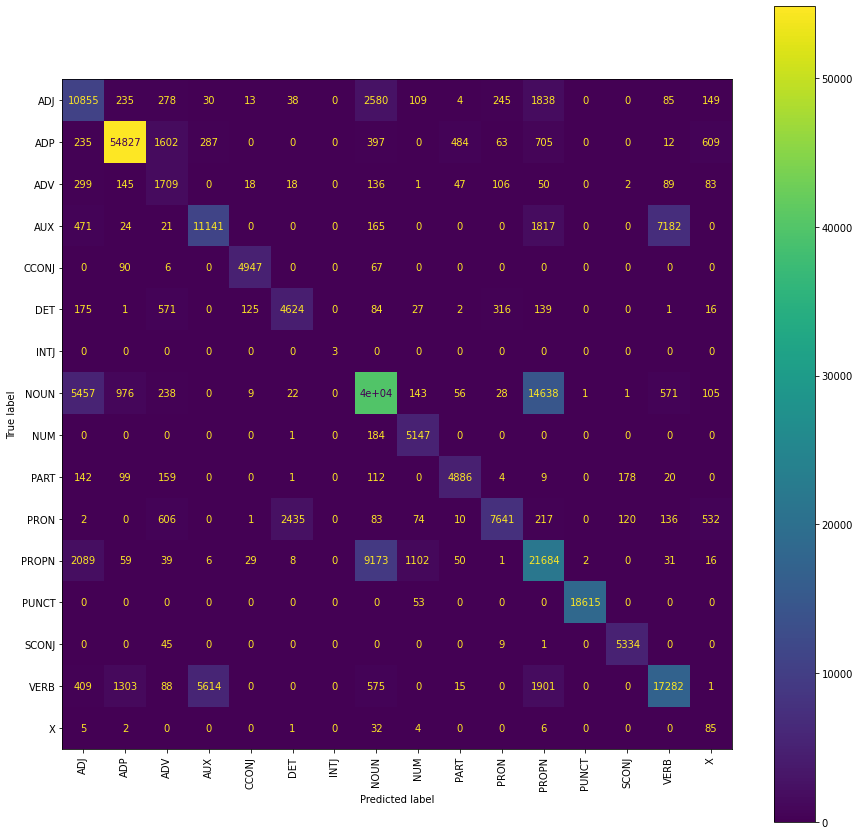

In [28]:
cm = confusion_matrix(flatten_ground_truth, flatten_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_list)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

cmd.plot(xticks_rotation='vertical', ax =ax)

### On Test Split

In [29]:
ground_truth = []
prediction = []
prev_pos = ''
prev_wrd = ' '

for every_sentence in test_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        word_norm = normalizer.normalize(word)
        ground_truth_sentence.append( label )
        
        if word_norm in INTJs:
            prediction_sentence.append('INTJ')
            
        elif chk_num(word_norm):
            prediction_sentence.append('NUM')
       
        elif chk_part(word_norm):
            prediction_sentence.append('PART')
            
        elif chk_sconj(word_norm):
            prediction_sentence.append('SCONJ')
            
        elif chk_aux(word_norm):
            prediction_sentence.append('AUX')
            
        elif chk_cconj(word_norm):
            prediction_sentence.append('CCONJ')
        
        elif chk_adp(word_norm):
            prediction_sentence.append('ADP')
            
        elif chk_det(word_norm):
            prediction_sentence.append('DET')
        
        elif word_norm in advs and prev_pos == 'ADP':
            prediction_sentence.append('ADV')
            
        else:
            if word_norm in word_pos_frequency:
                prediction_sentence.append( getMax( word_pos_frequency[word_norm] ) )
            else:
                prediction_sentence.append( random.choice( label_list ) )
        
        curr = prediction_sentence.pop()
        if (curr == 'VERB' or curr == 'ADJ') and (prev_pos != 'ADV') and (prev_wrd in advs) and (len(prediction_sentence) != 0):
            rem = prediction_sentence.pop()
            prediction_sentence.append('ADV')
        prediction_sentence.append(curr)
            
        prev_pos = prediction_sentence[len(prediction_sentence)-1]
        prev_wrd = word_norm
        
    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )


In [30]:
flatten_ground_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(accuracy_score(flatten_ground_truth, flatten_predictions))
print(classification_report(flatten_ground_truth, flatten_predictions, target_names=label_list, digits=4))

0.7076488851255998


C:\Users\akash\anaconda3\envs\nlplab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ     0.5016    0.6182    0.5538      2043
         ADP     0.9358    0.9259    0.9308      7544
         ADV     0.2431    0.6086    0.3474       304
         AUX     0.6338    0.5447    0.5859      2596
       CCONJ     0.8452    0.9717    0.9040       635
         DET     0.6128    0.7436    0.6719       745
        INTJ     0.0000    0.0000    0.0000         0
        NOUN     0.7270    0.5922    0.6527      8036
         NUM     0.6923    0.9481    0.8002       693
        PART     0.7736    0.8479    0.8090       677
        PRON     0.8292    0.6655    0.7384      1372
       PROPN     0.4411    0.4847    0.4619      4438
       PUNCT     0.9638    1.0000    0.9815      2420
       SCONJ     0.8491    0.9878    0.9132       655
        VERB     0.6504    0.5918    0.6197      3263
           X     0.0074    0.2222    0.0142         9

    accuracy                         0.7076     35430
   macro avg     0.6066   

C:\Users\akash\anaconda3\envs\nlplab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akash\anaconda3\envs\nlplab\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


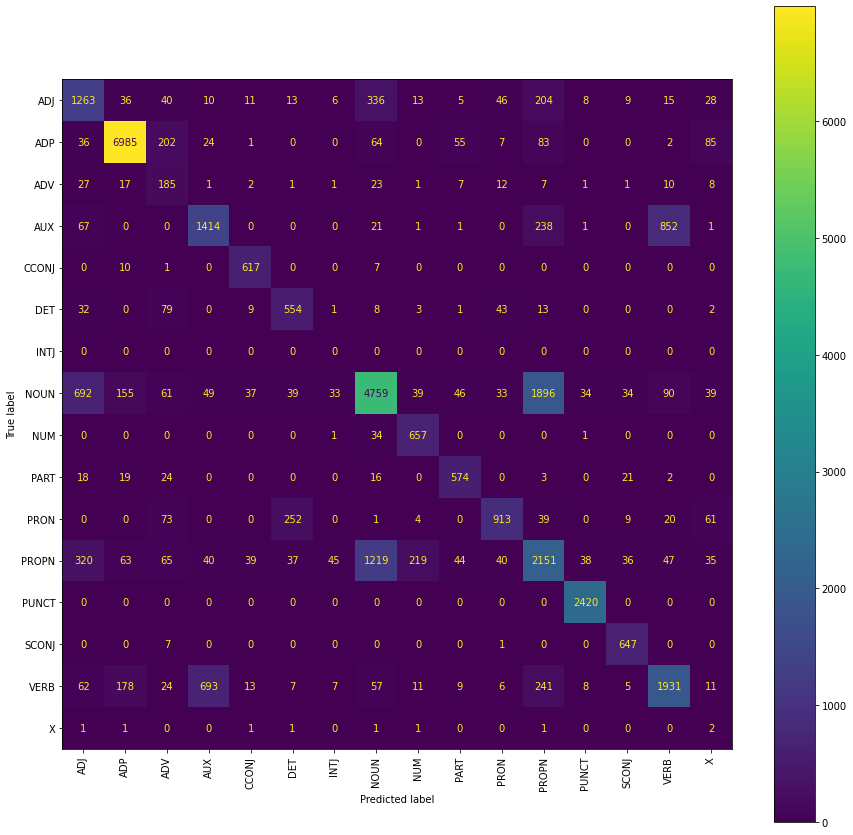

In [31]:
cm = confusion_matrix(flatten_ground_truth, flatten_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_list)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

cmd.plot(xticks_rotation='vertical', ax =ax)